In [1]:
import numpy as np
import pandas as pd
import os
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

## Reading the data

In [2]:
us_data_path = '/Users/ramtinyazdanian/Downloads/us_it_skills_2018_2019_10days/'
sg_data_path = '/Users/ramtinyazdanian/Downloads/sg_it_skills_2018_2019_15days/'

us_sheet_map = {'Report2_Data': 'companies', 'Report3_Data': 'skill_clusters', 
                    'Report4_Data_specialized': 'specialised_skills', 'Report4_Data_baseline': 'baseline_skills',
                    'Report4_Data_software': 'programming_skills'}

sg_sheet_map = {'Report1_Data': 'companies', 'Report2_Data': 'skill_clusters', 
                    'Report3_Data_specialised': 'specialised_skills', 'Report3_Data_baseline': 'baseline_skills',
                    'Report3_Data_software and progr': 'programming_skills'}

actual_sheet_map = us_sheet_map
root_data_path = us_data_path
all_filenames = os.listdir(root_data_path)
sheets_to_get = ['Filters']+list(actual_sheet_map.keys())

all_dataframes = [pd.read_excel(os.path.join(root_data_path,filename), sheet_name=sheets_to_get) 
                  for filename in all_filenames if filename[-4:] == 'xlsx' and filename[0] != '~']


In [3]:
time_period_index = -1
for i in range(all_dataframes[0]['Filters'].shape[0]):
    if all_dataframes[0]['Filters'].iloc[i][0] == 'Time Period:':
        time_period_index = i
        break

ad_count_index = -1
for i in range(all_dataframes[0]['Filters'].shape[0]):
    if all_dataframes[0]['Filters'].iloc[i][0] == 'Postings available with the current filters applied:':
        ad_count_index = i
        break
        
all_dataframes_dict = {all_dataframes[i]['Filters'].iloc[time_period_index][1].strip('Custom range (').strip(') '):
                       {v:all_dataframes[i][k].drop(columns=
                                            [x for x in all_dataframes[i][k].columns.values if 'Unnamed:' in x]) 
                        for k,v in actual_sheet_map.items()} 
                       for i in range(len(all_dataframes))}

ad_counts_dict = {all_dataframes[i]['Filters'].iloc[time_period_index][1].strip('Custom range (').strip(') '): 
                  all_dataframes[i]['Filters'].iloc[ad_count_index][1] for i in range(len(all_dataframes))}

In [4]:
all_dataframes_dict['Feb. 11, 2018 - Feb. 20, 2018']['programming_skills']

,Skill,Description,Job Postings
0,Java,Java is a set of computer software and specifi...,1280
1,Software Development,Software development is the process of compute...,1249
2,Software Engineering,Software engineering is the process of analyzi...,1111
3,SQL,"SQL ( ESS-kew-EL or SEE-kwl, Structured Query ...",1022
4,Oracle,Oracle Database (commonly referred to as Oracl...,727
...,...,...,...
495,Windows NT,Windows NT is a family of operating systems pr...,4
496,XAML,"Working experience of XAML, which is the langu...",4
497,XCTEST,"Working experience of XCTEST, which is used to...",4
498,jQuery Mobile,jQuery Mobile is a touch-optimized web framewo...,4


In [5]:
def get_concatenated_df_with_dates(df_dict, sheet_name, normalising_dict=None, use_log=False):
    if normalising_dict is None:
        return pd.concat([df_dict[k][sheet_name].assign(Date = 
                                   datetime.strptime(k.split('-')[0].strip(), '%b. %d, %Y')) 
                                   for k in df_dict]).reset_index().drop(columns='index')
    else:
        result = pd.concat([df_dict[k][sheet_name].assign(Date = 
                                   datetime.strptime(k.split('-')[0].strip(), '%b. %d, %Y')).
                                   assign(Total = normalising_dict[k])
                                   for k in df_dict]).reset_index().drop(columns='index')
        result['Job Postings Raw'] = result['Job Postings']
        if use_log:
            result['Job Postings'] = result['Job Postings'].apply(np.log)/result['Total'].apply(np.log)
        else:
            result['Job Postings'] = result['Job Postings']/result['Total']
        return result

In [13]:
get_concatenated_df_with_dates(all_dataframes_dict, 'companies').groupby('Employer').sum().sort_values(
                'Job Postings', ascending=False).reset_index().to_csv('./employer_postings.csv')

## Creating individual dataframes

In [462]:
skill_clusters_df = get_concatenated_df_with_dates(all_dataframes_dict, 
                                   'skill_clusters', normalising_dict=ad_counts_dict).\
                                   sort_values(['Date', 'Job Postings'], ascending=[True, False]).\
                                   reset_index().drop(columns='index')

In [609]:
skills_df = get_concatenated_df_with_dates(all_dataframes_dict, 
                                   'specialised_skills', normalising_dict=ad_counts_dict, use_log=False).\
                                   sort_values(['Date', 'Job Postings'], ascending=[True, False]).\
                                   reset_index().drop(columns='index')

In [610]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures

In [611]:
def linreg_jobpostings(df):
    y = PolynomialFeatures(degree=2, include_bias=False).fit_transform(df[['Job Postings']].values)
    X = df[['Date']].values
    X = (X - X.min()).astype('timedelta64[D]') / np.timedelta64(1, 'D') / 30
    result_model = LinearRegression()
    result_model.fit(X, y)
    return result_model.coef_[0][0], result_model.coef_[1][0], result_model.intercept_[0]

In [612]:
linreg_jobpostings(skills_df)

(0.00012163019005971317, 1.1415092124443777e-05, 0.019518084409273117)

Let's see the ad count time series:

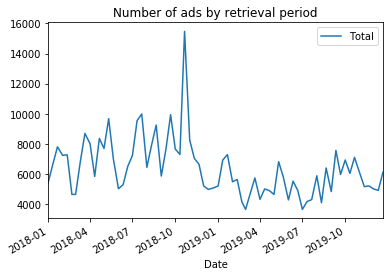

In [613]:
skills_df.groupby('Date').mean().reset_index().plot(x='Date', y='Total')
plt.title('Number of ads by retrieval period')
plt.show()

And the median market proportion among all the skills for each date.

In [614]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(skills_df.groupby('Date').median()[['Total', 'Job Postings']])

,Total,Job Postings
Date,,
2018-01-01,5455.0,0.011366
2018-01-11,6651.0,0.010600
2018-01-21,7820.0,0.008951
2018-02-01,7260.0,0.009229
2018-02-11,7286.0,0.007137
2018-02-21,4667.0,0.007928
2018-03-01,4667.0,0.016713
2018-03-11,6819.0,0.009899
2018-03-21,8707.0,0.009533


And the minimum number of ads among the skills that made it to the top 200 or 500 for each date.

In [615]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(skills_df.groupby('Date').min()[['Total', 'Job Postings Raw', 'Job Postings']])

,Total,Job Postings Raw,Job Postings
Date,,,
2018-01-01,5455,26,0.004766
2018-01-11,6651,30,0.004511
2018-01-21,7820,28,0.003581
2018-02-01,7260,27,0.003719
2018-02-11,7286,19,0.002608
2018-02-21,4667,14,0.003000
2018-03-01,4667,30,0.006428
2018-03-11,6819,28,0.004106
2018-03-21,8707,34,0.003905


In [616]:
skills_df.groupby('Date').min()[['Total', 'Job Postings Raw', 'Job Postings']].mean()

Total               6384.875000
Job Postings Raw      29.777778
Job Postings           0.004654
dtype: float64

Since one idea for resolving the missing value issue is to assign the minimum values above to the respective missing values, it's important to see what slope and intercept a skill with __missing values in everything__ would get if we used such a method to fill in the blanks.

In [617]:
linreg_jobpostings(
    skills_df.groupby('Date').min()[['Total', 'Job Postings Raw']].
    assign(jp = skills_df.groupby('Date').min()['Job Postings Raw'] / skills_df.groupby('Date').min()['Total']
          ).rename(columns = {'jp': 'Job Postings'}).
        reset_index())

(1.5826133376529365e-05, 1.0695765188866226e-07, 0.004464120940768755)

This is interesting because although the slope is quite low (1.58e-5 means a growth of 0.018% per year) but the intercept is 0.44%, which is pretty high to be honest.

Also, such a method of filling missing values in carries the risk of affecting different skills differently. For example, what if a skill was on the rise near the end but the market also expanded due to other reasons, and because of some high filled-in value in the middle, the slope ended up much lower than it should have been?

## Computing growth and initial popularity

In [618]:
skills_df

,Skill,Description,Job Postings,Date,Total,Job Postings Raw
0,Software Development,Software development is the process of compute...,0.238130,2018-01-01,5455,1299
1,Java,Java is a set of computer software and specifi...,0.215215,2018-01-01,5455,1174
2,SQL,"SQL ( ESS-kew-EL or SEE-kwl, Structured Query ...",0.201650,2018-01-01,5455,1100
3,Software Engineering,Software engineering is the process of analyzi...,0.149588,2018-01-01,5455,816
4,Oracle,Oracle Database (commonly referred to as Oracl...,0.143721,2018-01-01,5455,784
...,...,...,...,...,...,...
35995,Revenue Recognition,Experience working with an accounting principl...,0.005051,2019-12-21,6138,31
35996,Adobe Experience Manager (AEM),Working experience of Adobe Experience Manager...,0.004888,2019-12-21,6138,30
35997,Android,Android is a mobile operating system developed...,0.004888,2019-12-21,6138,30
35998,AppDynamics,Working experience of AppDynamics. AppDynamics...,0.004888,2019-12-21,6138,30


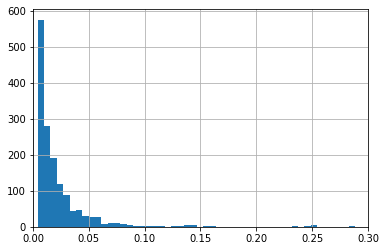

In [619]:
skills_df.loc[skills_df.Date.apply(lambda x: x.year == 2019 and x.month == 1), 'Job Postings'].hist(bins=50)
plt.xlim([0, 0.3])
plt.show()

In [620]:
def delete_low_freq_skills(df, min_freq):  
    skill_counts = skills_df.groupby('Skill').count().reset_index()
    low_count_skills = skill_counts.loc[skill_counts['Job Postings'] < min_freq].Skill.values
    return df.loc[df.Skill.apply(lambda x: x not in low_count_skills)]
    
def get_period_of_time(df, start, end):
    return df.loc[(df.Date >= start) & (df.Date < end)]

def fill_in_the_blank_dates(df, method='min'):
    columns_list = ['Job Postings', 'Job Postings Raw', 'Total']
    filling_df = df[['Date']+columns_list].groupby('Date')
    if method == 'min':
        filling_df = filling_df.min()
    elif method == 'mean':
        filling_df = filling_df.mean()
    elif method == 'median':
        filling_df = filling_df.median()
    elif method == 'zero':
        filling_df = filling_df.min()
        for col in columns_list:
            if col != 'Total':
                filling_df[col] = 0
    else:
        return df
    filling_df = filling_df.reset_index().assign(key_col=1)
    skills_only_df = df[['Skill']].drop_duplicates().assign(key_col=1)
    print('Number of skills: '+str(skills_only_df.shape[0]))
    filling_df = pd.merge(filling_df, skills_only_df, on='key_col').drop(columns=['key_col'])
    result_df = pd.merge(df, filling_df, how='right', on=['Skill', 'Date'], suffixes=('_actual', '_filled'))
    
    for col in columns_list:
        result_df[col+'_filled'] = result_df.apply(lambda x: x[col+'_filled'] if pd.isnull(x[col+'_actual']) else 
                                                  x[col+'_actual'], axis=1)
    result_df = result_df.drop(columns = [x+'_actual' for x in columns_list]).rename(
                                    columns={x+'_filled':x for x in columns_list})
    return result_df

def group_time_steps_together(df, steps_to_group=3):
    if steps_to_group == 1:
        return df
    dates_df = df[['Date']].drop_duplicates().sort_values('Date').reset_index().drop(columns=['index'])
    dates_df['group'] = pd.Series(list(range(dates_df.shape[0])))
    dates_df['group'] = dates_df['group'].apply(lambda x: 1 + (x//steps_to_group))
    print(dates_df)
    min_dates = dates_df.groupby('group').min().reset_index()
    result_df = pd.merge(df, dates_df, on='Date').drop(columns=['Date']).groupby(['group', 'Skill']).mean().\
                                    reset_index()
    result_df = pd.merge(result_df, min_dates, on='group').drop(columns=['group'])
    return result_df

Let's use linear regression to get the growth slope and the initial value (intercept) for each skill over time (we could use ridge to avoid overfitting, but that adds the question of what the regularisation coefficient should be, and that's one more arbitrary parameter).

In [621]:
skills_df_with_trends = pd.DataFrame(
    fill_in_the_blank_dates(
        group_time_steps_together(
            delete_low_freq_skills(
                get_period_of_time(
                    skills_df, np.datetime64('2018-01-01'), np.datetime64('2019-01-01')), 3), 
                                steps_to_group=1), method='zero').
                                             groupby('Skill').apply(linreg_jobpostings))

Number of skills: 847


Question: What do we do with single-count skills, i.e. skills that have appeared in the top 200 (or top 500) only once?

Answer: If we define emerging skills as those with their popularity below an upper bound but *also* above a certain minimum, then this problem is pretty much entirely solved. The problem is that given the minimum values we saw above (the minimum is presence in around 0.5% of that period's ads), our minimum may be a bit too high, and essentially, our emerging skills would be more skills that are emerging for the whole industry and less skills that are emerging for a smaller part of the industry.

In [622]:
skills_df.loc[skills_df.Skill.apply(lambda x: x in single_count_skills) & 
              skills_df.Date.apply(lambda x: x.year == 2019 and x.month > 10)]

,Skill,Description,Job Postings,Date,Total,Job Postings Raw
33402,Reliability Engineering Studies,Working experience of Reliability Engineering ...,0.006730,2019-11-01,6092,41
33786,IDMS,CA IDMS (Integrated Database Management System...,0.010423,2019-11-11,5181,54
33951,Cubes,"Working experience of Cubes, which is a light-...",0.005404,2019-11-11,5181,28
33954,Functional Programming,"In computer science, functional programming is...",0.005404,2019-11-11,5181,28
34353,BigFix,"Working experience of BigFix. BigFix, Inc. , w...",0.008220,2019-11-21,5231,43
34364,Azure Security,"Working experience of Azure Security, which pr...",0.007838,2019-11-21,5231,41
34379,Pega PRPC,Working experience of Pega PRPC. PRPC (PegaRUL...,0.007456,2019-11-21,5231,39
34436,Information Retrieval,Information retrieval (IR) is the activity of ...,0.006117,2019-11-21,5231,32
34459,Electronics Industry Knowledge,Working knowledge of the Electronics Industry ...,0.005544,2019-11-21,5231,29
34475,AWS Elastic Beanstalk,"""Working experience of AWS Elastic Beanstalk. ...",0.005162,2019-11-21,5231,27


In [623]:
def get_trend_slope_intercept(group_col_and_trends):
    group_col_and_trends['Slope'] = group_col_and_trends[0].apply(lambda x: x[0] if not 
                                                                               pd.isna(x) else np.nan)
    group_col_and_trends['Intercept'] = group_col_and_trends[0].apply(lambda x: x[2] if not 
                                                                               pd.isna(x) else np.nan)
    group_col_and_trends['Acceleration'] = group_col_and_trends[0].apply(lambda x: x[1] if not 
                                                                               pd.isna(x) else np.nan)
    group_col_and_trends = group_col_and_trends.drop(columns=0)
    return group_col_and_trends

### Specialised skills

Summary stats on the skill trends: slopes and intercepts

In [624]:
skills_df_with_trends = get_trend_slope_intercept(skills_df_with_trends)
skills_df_with_trends.sort_values('Slope', ascending=False).describe()

,Slope,Intercept,Acceleration
count,847.000000,847.000000,8.470000e+02
mean,0.000201,0.010735,1.377785e-05
std,0.000543,0.021124,8.563874e-05
min,-0.002516,-0.010226,-7.657152e-04
25%,-0.000046,0.000566,-4.196518e-07
50%,0.000103,0.004208,1.114800e-06
75%,0.000311,0.011512,5.984260e-06
max,0.007172,0.230022,1.321317e-03


In [625]:
high_slope_skills = skills_df_with_trends.sort_values('Slope', ascending=False).head(300).index.values
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(skills_df.loc[skills_df.Skill.apply(lambda x: x in high_slope_skills)].groupby('Skill').count())

,Description,Job Postings,Date,Total,Job Postings Raw
Skill,,,,,
.NET,72,72,72,72,72
API Management,53,53,53,53,53
ASP.NET,72,72,72,72,72
Account Consultations,7,7,7,7,7
Account Development,10,10,10,10,10
Active Server Pages (ASP),72,72,72,72,72
Adobe Acrobat,68,68,68,68,68
Adobe Illustrator,59,59,59,59,59
Adobe Indesign,67,67,67,67,67


A peek at the highest-growing skills (slope is growth percentage per month)

In [626]:
skills_df_with_trends.sort_values('Slope', ascending=False).head(60)

,Slope,Intercept,Acceleration
Skill,,,
Fiserv,0.007172,-0.010226,0.000508
Information Technology Industry Knowledge,0.004888,0.014715,0.000504
Project Management,0.003479,0.111177,0.000875
SQL,0.003445,0.196842,0.001321
Customer Service,0.003249,0.095438,0.000697
Data Security,0.002779,0.000547,0.000150
Python,0.002559,0.116178,0.000576
Software Development,0.002333,0.217187,0.000893
Data Privacy,0.002281,-0.002080,0.000099


And the skills that have the greatest initial ad shares

In [627]:
skills_df_with_trends.sort_values('Intercept', ascending=False).head(60)

,Slope,Intercept,Acceleration
Skill,,,
Java,0.000023,0.230022,-0.000168
Software Development,0.002333,0.217187,0.000893
SQL,0.003445,0.196842,0.001321
Software Engineering,-0.002060,0.172570,-0.000766
Linux,0.001345,0.138457,0.000311
Oracle,-0.000290,0.135651,-0.000118
JavaScript,0.001139,0.119627,0.000187
Python,0.002559,0.116178,0.000576
Project Management,0.003479,0.111177,0.000875


And the fastest accelerating skills

In [628]:
skills_df_with_trends.sort_values('Acceleration', ascending=False).head(60)

,Slope,Intercept,Acceleration
Skill,,,
SQL,0.003445,0.196842,0.001321
Software Development,0.002333,0.217187,0.000893
Project Management,0.003479,0.111177,0.000875
Customer Service,0.003249,0.095438,0.000697
Python,0.002559,0.116178,0.000576
Fiserv,0.007172,-0.010226,0.000508
Information Technology Industry Knowledge,0.004888,0.014715,0.000504
Linux,0.001345,0.138457,0.000311
Information Systems,0.001657,0.070908,0.000261


Now let's see the skills that meet a certain set of criteria for being trending: relatively high slope and relatively low intercept (i.e. initial value), meaning that they weren't that popular to begin with, but are growing fast. The percentiles used are, again, parameters to be set, and could be rather arbitrary.

It's also worth noting that the results here look a bit better for "specialised skills" than for "programming skills" because the latter seem to be too granular and their slope values look abysmally low.

In [634]:
intercept_thresh = 0.25
slope_thresh = 0.75
accel_thresh = 0.75
skills_df_with_trends.loc[(skills_df_with_trends.Slope >= skills_df_with_trends.Slope.quantile(slope_thresh)) & 
              (skills_df_with_trends.Intercept <= skills_df_with_trends.Intercept.quantile(intercept_thresh))].\
              sort_values('Slope', ascending=False).shape

(27, 4)

In [635]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(skills_df_with_trends.loc[(skills_df_with_trends.Slope >= 
                                       skills_df_with_trends.Slope.quantile(slope_thresh)) & 
                  (skills_df_with_trends.Intercept <= skills_df_with_trends.Intercept.quantile(intercept_thresh))].\
                  sort_values('Slope', ascending=False))

,Slope,Intercept,Acceleration,combined_score
Skill,,,,
Fiserv,0.007172,-0.010226,0.000508,-7.386476e-05
Data Security,0.002779,0.000547,0.000150,1.520205e-06
Data Privacy,0.002281,-0.002080,0.000099,-4.752904e-06
DNA,0.001593,-0.002772,0.000046,-4.424507e-06
Core banking,0.000900,-0.002219,0.000022,-2.000296e-06
Sales Planning,0.000891,-0.001918,0.000015,-1.711291e-06
Good Clinical Practices (GCP),0.000776,0.000526,0.000008,4.079154e-07
Remote Technical Support,0.000775,-0.001314,0.000012,-1.018314e-06
Management Consulting,0.000731,-0.001648,0.000007,-1.205009e-06


In [636]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(skills_df_with_trends.loc[(skills_df_with_trends.Acceleration >= 
                                       skills_df_with_trends.Acceleration.quantile(accel_thresh)) & 
                  (skills_df_with_trends.Intercept <= skills_df_with_trends.Intercept.quantile(intercept_thresh))].\
                  sort_values('Acceleration', ascending=False))

,Slope,Intercept,Acceleration,combined_score
Skill,,,,
Fiserv,0.007172,-0.010226,0.000508,-7.386476e-05
Data Security,0.002779,0.000547,0.000150,1.520205e-06
Data Privacy,0.002281,-0.002080,0.000099,-4.752904e-06
DNA,0.001593,-0.002772,0.000046,-4.424507e-06
Core banking,0.000900,-0.002219,0.000022,-2.000296e-06
Customer Accounts,0.000728,0.000322,0.000017,2.347297e-07
Sales Planning,0.000891,-0.001918,0.000015,-1.711291e-06
Problem Analysis,0.000474,-0.000463,0.000014,-2.195907e-07
Remote Technical Support,0.000775,-0.001314,0.000012,-1.018314e-06


In [632]:
skills_df_with_trends['combined_score'] = skills_df_with_trends.apply(lambda x: 
                         x['Slope']*np.log(1+x['Intercept'])*(1+2*x['Acceleration'])**2, axis=1)

In [633]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(skills_df_with_trends.sort_values('combined_score', ascending=False))

,Slope,Intercept,Acceleration,combined_score
Skill,,,,
SQL,3.444520e-03,0.196842,1.321317e-03,6.222081e-04
Software Development,2.333407e-03,0.217187,8.930122e-04,4.602534e-04
Project Management,3.479058e-03,0.111177,8.749323e-04,3.680471e-04
Customer Service,3.249438e-03,0.095438,6.972864e-04,2.970282e-04
Python,2.559426e-03,0.116178,5.759723e-04,2.819549e-04
Linux,1.345028e-03,0.138457,3.111558e-04,1.746320e-04
JavaScript,1.138867e-03,0.119627,1.868070e-04,1.287833e-04
Information Systems,1.657088e-03,0.070908,2.605154e-04,1.136403e-04
Microsoft C#,1.569384e-03,0.069291,2.489578e-04,1.052471e-04


What if we didn't just look at the lowest-intercept skills, but rather at an interval somewhere in the middle?

In [600]:
skills_df_with_trends.loc['jQuery']

Slope             0.000307
Intercept         0.035740
Acceleration      0.000025
combined_score   -0.034760
Name: jQuery, dtype: float64

### Skill clusters

The skill cluster growths are also really, really low, even lower than the programming skills, and I really don't think we can rely on them.

In [517]:
skillclusters_df_with_trends = pd.DataFrame(skill_clusters_df.
                                     groupby('Skill Cluster').apply(linreg_jobpostings))
skillclusters_df_with_trends = get_trend_slope_intercept(skillclusters_df_with_trends)
skillclusters_df_with_trends.sort_values('Slope', ascending=False).describe()

,Slope,Intercept,Acceleration
count,305.000000,305.000000,3.050000e+02
mean,0.000332,0.029878,5.005075e-05
std,0.002424,0.047260,2.318819e-04
min,-0.006211,0.003019,-4.804599e-04
25%,-0.000002,0.006859,-2.755413e-07
50%,0.000102,0.010776,1.809899e-06
75%,0.000310,0.029720,1.184193e-05
max,0.040551,0.380283,2.595406e-03


In [518]:
skillclusters_df_with_trends.sort_values('Slope', ascending=False)

,Slope,Intercept,Acceleration
Skill Cluster,,,
Public Safety and National Security: Loss Prevention,0.040551,0.012579,0.001568
Information Technology: Software Development Principles,0.003137,0.380283,0.002595
Information Technology: SQL Databases and Programming,0.002868,0.229097,0.001442
Information Technology: Cloud Solutions,0.002825,0.118378,0.000832
Information Technology: Software Development Methodologies,0.002799,0.094216,0.000706
...,...,...,...
Marketing and Public Relations: Corporate Communications,-0.001185,0.025812,-0.000045
Information Technology: Systems Administration,-0.001217,0.177687,-0.000408
Business: Pricing Analysis,-0.001814,0.015939,-0.000039


In [519]:
it_clusters = skillclusters_df_with_trends.reset_index().loc[
                    skillclusters_df_with_trends.reset_index()['Skill Cluster'].
                       apply(lambda x: 'information technology' in x.lower())]

display(it_clusters.loc[(it_clusters.Slope >= it_clusters.Slope.quantile(0.5)) & 
                        (it_clusters.Intercept <= it_clusters.Intercept.quantile(0.75))
                      ].sort_values('Slope', ascending=False))

,Skill Cluster,Slope,Intercept,Acceleration
181,Information Technology: IT Automation,0.002305,0.038053,0.000306
217,Information Technology: Software Development T...,0.002131,0.072715,0.000415
224,Information Technology: Version Control,0.001378,0.063921,0.000219
154,Information Technology: Big Data,0.001189,0.074333,0.000208
183,Information Technology: Information Security,0.000994,0.033987,0.000082
176,"Information Technology: Extraction, Transforma...",0.000954,0.062558,0.000136
223,Information Technology: Test Automation,0.000935,0.073131,0.000154
225,Information Technology: Virtual Machines (VM),0.000882,0.076128,0.000146
203,Information Technology: NoSQL Databases,0.000830,0.049816,0.000096
182,Information Technology: IT Management,0.000741,0.076558,0.000113
